In [1]:
import numpy as np
import numpy.fft as fft
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import signal
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision
import torchaudio
from torchvision import transforms
import cv2
%matplotlib inline
from utils import MindBigData, GetDataSet, GetDataLoaders, GetDataLoadersEEGImages, GetDataAndPreProcess
import time


seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# download dataset to google drive
def DownloadDataSet(link, drive_path, colab_path, filename):
    ! wget -c -P "{drive_path}" "{link}"
    !unzip "{drive_path}/{filename}" -d "{drive_path}"
    !cp -r "{drive_path}" "{colab_path}"

In [ ]:
link = 'http://www.mindbigdata.com/opendb/MindBigData-EP-v1.0.zip'
drive_path = '/content/drive/MyDrive/DLProj/data/'
colab_path = '.'

DownloadDataSet(link, drive_path, colab_path,"MindBigData-EP-v1.0.zip")

In [4]:
x, y = GetDataAndPreProcess(input_file="data/EP1.01.txt", samples_per_digit=6500)

[6466, 6324, 6443, 6500, 6304, 6500, 6478, 6293, 6494, 6500]


In [5]:
train_loader, valid_loader, test_loader = GetDataLoaders(x, y, batch_size=64)

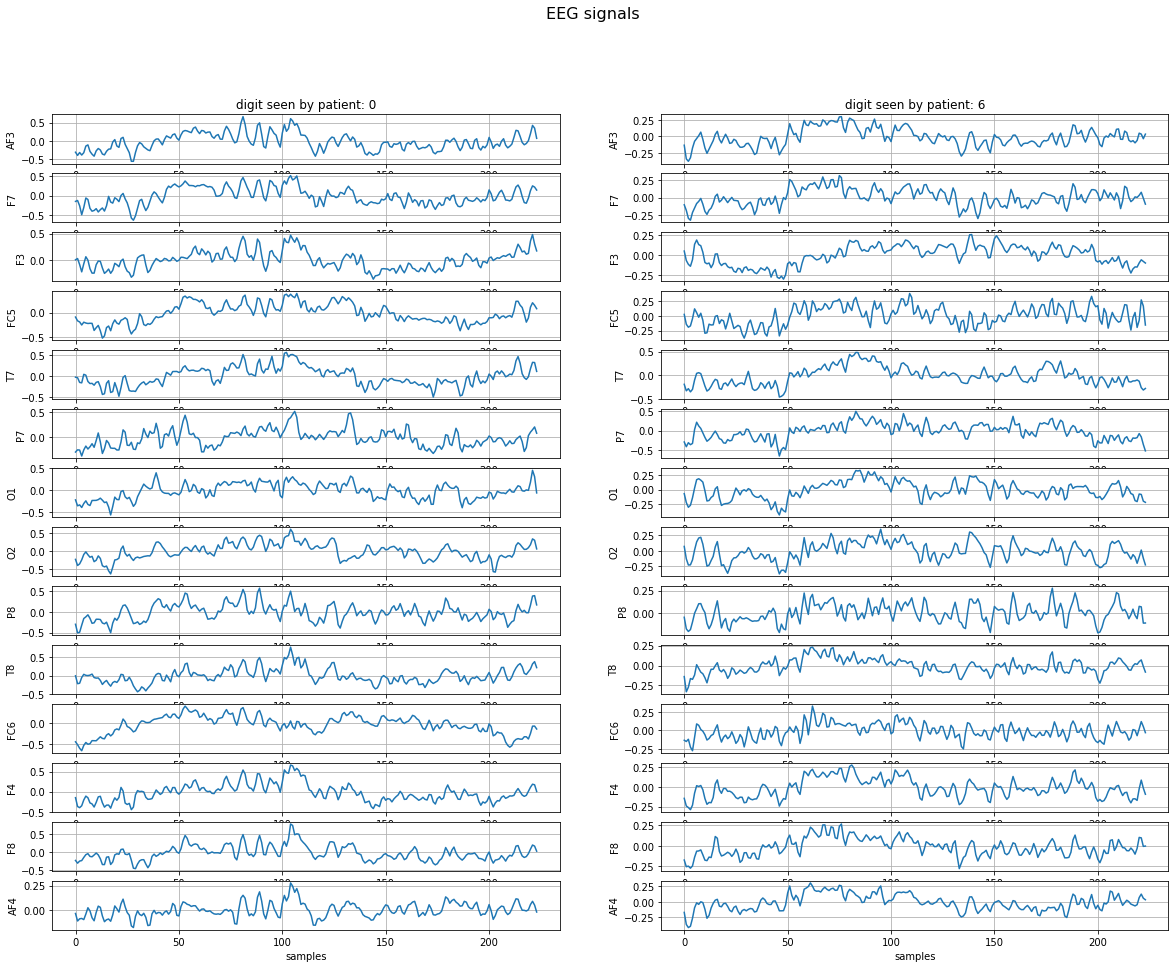

In [6]:
# Display 2 signals with their labels
data_iter = iter(train_loader)
inputs, labels = data_iter.next()
EEGChannel = ["AF3", "F7", "F3", "FC5", "T7", "P7", "O1", "O2", "P8", "T8", "FC6", "F4", "F8", "AF4"]

fig = plt.figure(figsize=(20, 15))
fig.suptitle('EEG signals', fontsize=16)
for i in range(2):
    for j in range(14):
        ax = fig.add_subplot(14, 2, i + 1 + 2 * j)
        if (j == 0):
            ax.set_title(
                'digit seen by patient: ' + str(labels[i].item()))  # .item() gets the value contained in a tensor
        ax.plot(inputs[i][j])
        ax.set_xlabel('samples')
        ax.set_ylabel(EEGChannel[j])
        ax.grid()

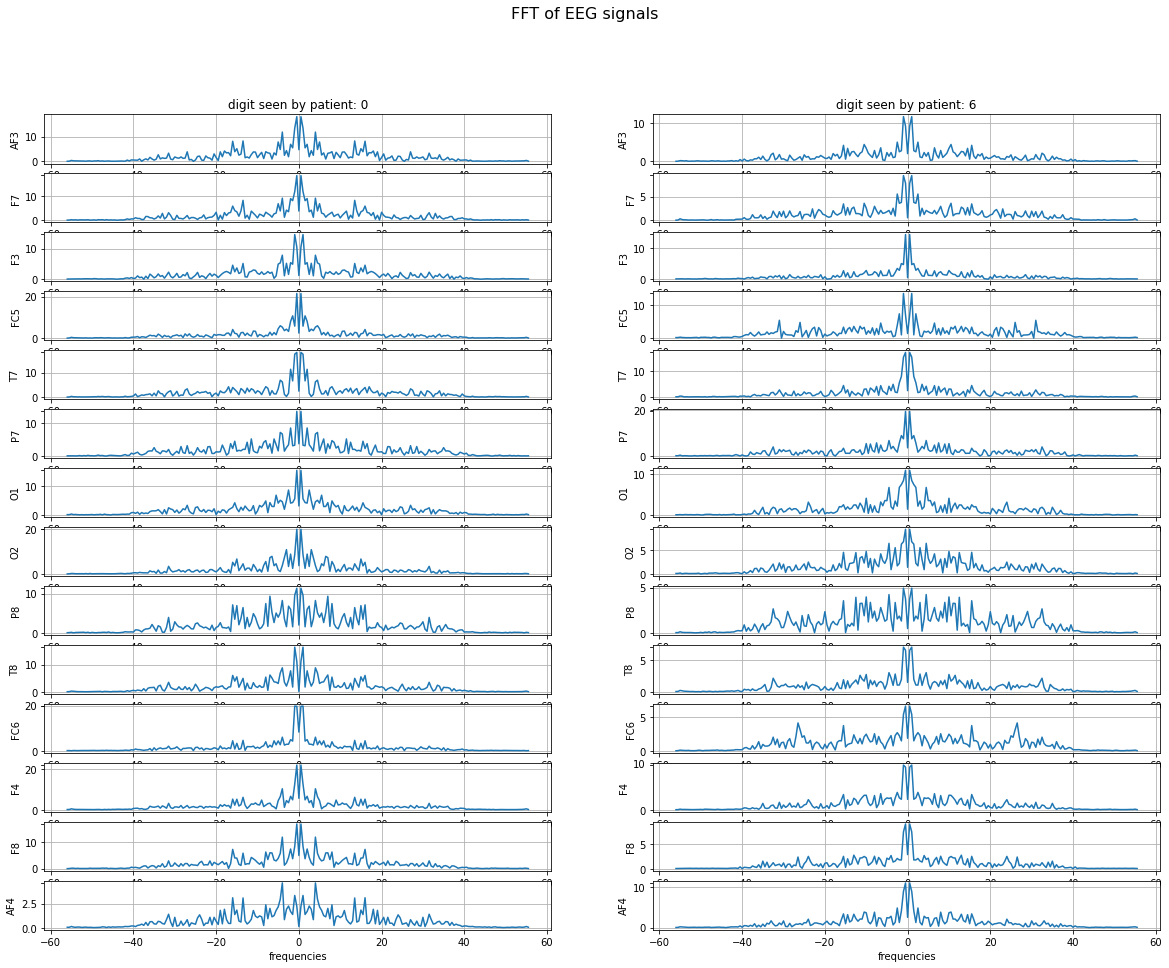

In [7]:
# Display 2 FFT of signals with their labels
f = np.arange(-112, 112) * 0.5
fig = plt.figure(figsize=(20, 15))
fig.suptitle('FFT of EEG signals', fontsize=16)
for i in range(2):
    for j in range(14):
        ax = fig.add_subplot(14, 2, i + 1 + 2 * j)
        if (j == 0):
            ax.set_title(
                'digit seen by patient: ' + str(labels[i].item()))  # .item() gets the value contained in a tensor
        ax.plot(f, abs(fft.fftshift(fft.fft(inputs[i][j]))))
        ax.set_xlabel('frequencies')
        ax.set_ylabel(EEGChannel[j])
        ax.grid()

In [8]:
class CNN(nn.Module):
    def __init__(self, num_channel=10, num_classes=4, signal_length=1000, 
                 filters_n1=4, kernel_window_eeg=39, kernel_window=19, 
                 conv_3_dilation=4, conv_4_dilation=4):
        super().__init__()

        filters = [filters_n1, filters_n1 * 2]

        self.conv_1 = Conv2dBlockELU(in_ch=1, out_ch=filters[0], kernel_size=(1, kernel_window_eeg), w_in=signal_length)

        self.conv_1_1 = Conv2dBlockELU(in_ch=filters[0], out_ch=filters[0], kernel_size=(1, kernel_window_eeg), w_in=self.conv_1.w_out)

        self.conv_2 = Conv2dBlockELU(in_ch=filters[0], out_ch=filters[0], kernel_size=(num_channel, 1))

        self.conv_3 = Conv2dBlockELU(in_ch=filters[0], out_ch=filters[1], kernel_size=(1, kernel_window),
                                     padding=(0,conv_3_dilation-1), dilation=(1,conv_3_dilation), w_in=self.conv_1.w_out)
        
        self.conv_4 = Conv2dBlockELU(in_ch=filters[1], out_ch=filters[1], kernel_size=(1, kernel_window),
                                     padding=(0,conv_4_dilation-1), dilation=(1,conv_4_dilation), w_in=self.conv_3.w_out)

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(480, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 10),
        )

        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = torch.unsqueeze(x, 1)

        # conv layers
        x = self.conv_1(x)
        x = self.conv_1_1(x)
        x = self.conv_2(x)
        x = self.dropout(x)
        x = self.conv_3(x)
        x = self.conv_4(x)
        x = self.dropout(x)

        # flatten
        x = x.view(x.size(0), -1)

        # fc layers
        x = self.fc_layer(x)

        return x


class Conv2dBlockELU(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, padding=(0,0), dilation=(1,1), groups=1, w_in=None):
        super(Conv2dBlockELU, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding=padding, dilation=dilation, groups=groups),
            nn.BatchNorm2d(out_ch),
            nn.ELU(inplace=True)
        )

        if w_in is not None:
            self.w_out = int( ((w_in + 2 * padding[1] - dilation[1] * (kernel_size[1]-1)-1) / 1) + 1 )

        self.out_ch = out_ch

    def forward(self, x):
        return self.conv(x)

In [9]:
model = CNN(
        num_channel = 14,
        num_classes = 10,
        signal_length = 224,
        kernel_window_eeg = 32,
        filters_n1 = 8,
    ).to(device)
print("Model Architecture:")
print(model)

Model Architecture:
CNN(
  (conv_1): Conv2dBlockELU(
    (conv): Sequential(
      (0): Conv2d(1, 8, kernel_size=(1, 32), stride=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
  )
  (conv_1_1): Conv2dBlockELU(
    (conv): Sequential(
      (0): Conv2d(8, 8, kernel_size=(1, 32), stride=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
  )
  (conv_2): Conv2dBlockELU(
    (conv): Sequential(
      (0): Conv2d(8, 8, kernel_size=(14, 1), stride=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
  )
  (conv_3): Conv2dBlockELU(
    (conv): Sequential(
      (0): Conv2d(8, 16, kernel_size=(1, 19), stride=(1, 1), padding=(0, 3), dilation=(1, 4))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_

In [10]:
### Helper Functions ###
# function to calcualte accuracy of the model
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

def calculate_accuracy(model, dataloader, device, criterion):
    model.eval() # put in evaluation mode
    total_correct = 0
    total_images = 0
    running_loss = 0.0
    confusion_matrix = np.zeros([10,10], int)
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.float()
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels) # calculate the loss
            running_loss += loss.data.item()
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            for i, l in enumerate(labels):
                confusion_matrix[l.item(), predicted[i].item()] += 1

    # Normalizing the loss by the total number of train batches
    running_loss /= len(dataloader)
    model_accuracy = total_correct / total_images * 100
    return model_accuracy, confusion_matrix, running_loss

# use a different initialization for the model
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.bias, 0, 0.005)
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

In [11]:
def compile_model(model):
    # hyper-parameters
    learning_rate = 0.06
    epochs = 200
    weight_decay = 9e-4
    batch_size = 215

    # get data loaders
    train_loader, valid_loader, test_loader = GetDataLoaders(x, y, batch_size)

    # loss criterion
    criterion = nn.CrossEntropyLoss()

    # optimizer - SGD, Adam, RMSProp...
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, 
                                    weight_decay=weight_decay)
    
    # Learning Rate Scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, 
                                  verbose=True)
    
    # Early Stopping
    early_stopping = EarlyStopping(delta=0.00, patience=10, verbose=True)

    # training loop
    train_losses = []
    valid_losses = []
    for epoch in range(1, epochs + 1):
        model.train() # put in training mode
        running_loss = 0.0
        total_correct = 0
        total_images = 0
        epoch_time = time.time()
        for train_data in train_loader:
            # get the inputs
            inputs, labels = train_data
            # send them to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward + backward + optimize
            outputs = model(inputs) # forward pass
            loss = criterion(outputs, labels) # calculate the loss

            # always the same 3 steps
            loss.backward() # backpropagation
            optimizer.step() # update parameters
            optimizer.zero_grad() # zero the parameter gradients

            # calc accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()

            # print statistics
            running_loss += loss.data.item()

        # Normalizing the loss by the total number of train batches
        running_loss /= len(train_loader)
        train_losses.append(running_loss)

        # Calculate training/test set accuracy of the existing model
        train_accuracy = total_correct / total_images * 100
        valid_accuracy, _, valid_loss = calculate_accuracy(model, valid_loader, device, criterion)
        valid_losses.append(valid_loss)

        log = "Epoch: {} | Train Loss: {:.4f} | Training accuracy: {:.3f}% | Validation Loss: {:.3f} | Validation accuracy: {:.3f}% | ".format(epoch
        , running_loss, train_accuracy, valid_loss, valid_accuracy)
        epoch_time = time.time() - epoch_time
        log += "Epoch Time: {:.2f} secs".format(epoch_time)
        print(log)

        # accuracy is used to track down a plateau
        scheduler.step(valid_loss) 

        # Early Stopping
        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            break

    print('==> Finished Training ...')
    
    # calculate accuracy and confusion matrix
    test_accuracy, confusion_matrix, _ = calculate_accuracy(model, test_loader, device, criterion)
    print("test accuracy: {:.3f}%".format(test_accuracy))

    # plot confusion matrix
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
    plt.ylabel('Actual Category')
    plt.yticks(range(10), range(10))
    plt.xlabel('Predicted Category')
    plt.xticks(range(10), range(10))
    plt.show()

    # print loss curves
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss')

Epoch: 1 | Train Loss: 2.3142 | Training accuracy: 11.071% | Validation Loss: 2.288 | Validation accuracy: 12.846% | Epoch Time: 8.75 secs
Validation loss decreased (inf --> 2.287762).  Saving model ...
Epoch: 2 | Train Loss: 2.2951 | Training accuracy: 12.479% | Validation Loss: 2.285 | Validation accuracy: 13.199% | Epoch Time: 8.22 secs
Validation loss decreased (2.287762 --> 2.285210).  Saving model ...
Epoch: 3 | Train Loss: 2.2884 | Training accuracy: 13.090% | Validation Loss: 2.282 | Validation accuracy: 13.603% | Epoch Time: 8.16 secs
Validation loss decreased (2.285210 --> 2.281748).  Saving model ...
Epoch: 4 | Train Loss: 2.2815 | Training accuracy: 13.895% | Validation Loss: 2.276 | Validation accuracy: 14.007% | Epoch Time: 8.18 secs
Validation loss decreased (2.281748 --> 2.276295).  Saving model ...
Epoch: 5 | Train Loss: 2.2752 | Training accuracy: 14.492% | Validation Loss: 2.272 | Validation accuracy: 14.598% | Epoch Time: 8.18 secs
Validation loss decreased (2.27629

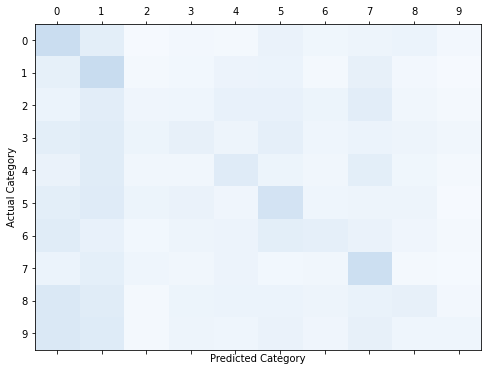

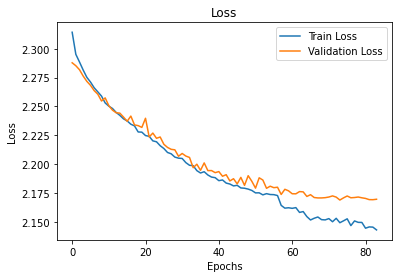

In [12]:
model = CNN(
        num_channel = 14,
        num_classes = 10,
        signal_length = 224,
        kernel_window_eeg = 32,
        filters_n1 = 8,
    ).to(device)
compile_model(model=model)

# Compile with Optuna

In [ ]:
!pip install optuna
import optuna

In [14]:
def compile_model(trial):
    # hyper-parameters
    epochs = 200
    learning_rate = trial.suggest_float("learning_rate", 1e-2, 1e-1, log=True) # log=True, will use log scale
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True) # log=True, will use log scale
    batch_size = trial.suggest_int("batch_size", 64, 256) # batch_size will be between 64 and 256

    # Generate the model
    model = CNN(
        num_channel = 14,
        num_classes = 10,
        signal_length = 224,
        kernel_window_eeg = 32,
        filters_n1 = 8,
    ).to(device)

    # load data
    train_loader, valid_loader, test_loader = GetDataLoaders(x, y, batch_size=batch_size)

    # loss criterion
    criterion = nn.CrossEntropyLoss()

    # optimizer - SGD, Adam, RMSProp...
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=learning_rate, 
                                               weight_decay=weight_decay)
    
    # Learning Rate Scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=50, 
                                  verbose=True)
    
    # Early Stopping
    early_stopping = EarlyStopping(delta=0.00, patience=10, verbose=True)

    # training loop
    train_losses = []
    valid_losses = []
    for epoch in range(1, epochs + 1):
        model.train() # put in training mode
        running_loss = 0.0
        total_correct = 0
        total_images = 0
        epoch_time = time.time()
        for train_data in train_loader:
            # get the inputs
            inputs, labels = train_data
            # send them to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward + backward + optimize
            outputs = model(inputs) # forward pass
            loss = criterion(outputs, labels) # calculate the loss

            # always the same 3 steps
            loss.backward() # backpropagation
            optimizer.step() # update parameters
            optimizer.zero_grad() # zero the parameter gradients

            # calc accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()

            # print statistics
            running_loss += loss.data.item()

        # Normalizing the loss by the total number of train batches
        running_loss /= len(train_loader)
        train_losses.append(running_loss)

        # Calculate training and validation set accuracy of the existing model
        train_accuracy = total_correct / total_images * 100
        valid_accuracy, _, valid_loss = calculate_accuracy(model, valid_loader, device, criterion)
        valid_losses.append(valid_loss)

        log = "Epoch: {} | Train Loss: {:.4f} | Training accuracy: {:.3f}% | Validation Loss: {:.3f} | Validation accuracy: {:.3f}% | ".format(epoch
        , running_loss, train_accuracy, valid_loss, valid_accuracy)
        epoch_time = time.time() - epoch_time
        log += "Epoch Time: {:.2f} secs".format(epoch_time)
        print(log)

        # accuracy is used to track down a plateau
        scheduler.step(valid_accuracy) 

        # Early Stopping
        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            break

        # report back to Optuna how far it is (epoch-wise) into the trial and how 
        # well it is doing (validation accuracy)
        trial.report(valid_accuracy, epoch) 
        
        # then, Optuna can decide if the trial should be pruned
        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    print('==> Finished Training ...')
    
    # print loss curves
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss')

    # calculate accuracy and confusion matrix
    test_accuracy, confusion_matrix, _ = calculate_accuracy(model, test_loader, device, criterion)
    print("test accuracy: {:.3f}%".format(test_accuracy))

    # plot confusion matrix
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
    plt.ylabel('Actual Category')
    plt.yticks(range(10), range(10))
    plt.xlabel('Predicted Category')
    plt.xticks(range(10), range(10))
    plt.show()

    return valid_accuracy

In [ ]:
# Compile with Optuna
sampler = optuna.samplers.TPESampler()
study = optuna.create_study(study_name="EEG-CNN", direction="maximize", sampler=sampler)
study.optimize(compile_model, n_trials=2)
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
print("Study statistics: ")
print(" Number of finished trials: ", len(study.trials))
print(" Number of pruned trials: ", len(pruned_trials))
print(" Number of complete trials: ", len(complete_trials))
print("Best trial:")
trial = study.best_trial
print(" Value: ", trial.value)
print(" Params: ")
for key, value in trial.params.items():
 print(" {}: {}".format(key, value))


In [ ]:
 optuna.visualization.plot_param_importances(study)